In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [56]:
df = pd.read_parquet('../Dataframes/df.parquet.gzip')

In [58]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [3]:
'''
Change the normalization to be (0, 1)
'''

'\nChange the normalization to be (0, 1)\n'

In [60]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.3 * len(data))


# feed the lstm with all features starting from the open price
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [61]:
input_data

array([[0.41251653, 0.41280745, 0.42930676, ..., 0.46913067, 0.36107467,
        0.21184698],
       [0.40877038, 0.41424773, 0.42065491, ..., 0.41475371, 0.35501519,
        0.21448553],
       [0.40788894, 0.41435852, 0.4225167 , ..., 0.38691739, 0.35581214,
        0.21689679],
       ...,
       [0.08946673, 0.09273211, 0.10984558, ..., 0.66828302, 0.65686441,
        0.62213368],
       [0.08737329, 0.08951917, 0.10447925, ..., 0.65676381, 0.65939083,
        0.62156358],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [62]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

33

In [63]:
input_data

array([[0.41251653, 0.41280745, 0.42930676, ..., 0.46913067, 0.36107467,
        0.21184698],
       [0.40877038, 0.41424773, 0.42065491, ..., 0.41475371, 0.35501519,
        0.21448553],
       [0.40788894, 0.41435852, 0.4225167 , ..., 0.38691739, 0.35581214,
        0.21689679],
       ...,
       [0.08946673, 0.09273211, 0.10984558, ..., 0.66828302, 0.65686441,
        0.62213368],
       [0.08737329, 0.08951917, 0.10447925, ..., 0.65676381, 0.65939083,
        0.62156358],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [64]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data) - test_size - lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [66]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-(test_size+lookback):]

# cut the test data out
X = X[:-(test_size + lookback)]
y = y[:-(test_size + lookback)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(1952, 50, 33)

In [67]:
file = "./Models/" + "Model" + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    # model.save(file)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            7680      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 22,351
Trainable params: 22,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1952/1952 [==============================] - 4s 2ms/step - loss: 0.0445
Epoch 2/5
1952/1952 [==============================] - 3s 1ms/step - loss: 7.0160e-04
Epoch 3/5
1952/1952 [==============================] - 3s 1ms/step - loss: 3.830

In [68]:
'''
Edited the block below
'''

'\nEdited the block below\n'

In [70]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li):
    input_data[i][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data

array([[   1.5829    ,    1.5773    ,    1.5761    , ..., -374.3802858 ,
        -405.04202878, -553.76891235],
       [   1.5795    ,    1.5786    ,    1.5682    , ..., -528.94048398,
        -418.45008892, -548.46832713],
       [   1.5787    ,    1.5787    ,    1.5699    , ..., -608.06200039,
        -416.68663927, -543.62436522],
       ...,
       [   1.66678812,    1.2884    ,    1.2844    , ...,  191.6871429 ,
         249.46465099,  270.45338208],
       [   1.66360125,    1.2855    ,    1.2795    , ...,  158.94511761,
         255.05495269,  269.30810735],
       [   1.6578167 ,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [71]:
actual_data = data.iloc[:, 1:].values
actual_data

array([[   1.5829    ,    1.5773    ,    1.5761    , ..., -374.3802858 ,
        -405.04202878, -553.76891235],
       [   1.5795    ,    1.5786    ,    1.5682    , ..., -528.94048398,
        -418.45008892, -548.46832713],
       [   1.5787    ,    1.5787    ,    1.5699    , ..., -608.06200039,
        -416.68663927, -543.62436522],
       ...,
       [   1.2897    ,    1.2884    ,    1.2844    , ...,  191.6871429 ,
         249.46465099,  270.45338208],
       [   1.2878    ,    1.2855    ,    1.2795    , ...,  158.94511761,
         255.05495269,  269.30810735],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

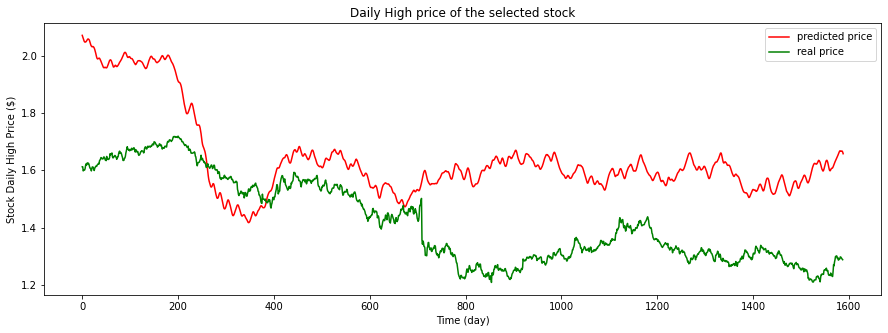

In [73]:
plt.figure(figsize=(15,5))
plt.plot(input_data[-(test_size+lookback):,0], color= 'red', label="predicted price")
plt.plot(actual_data[-(test_size+lookback):,0], color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()